## This notebook is dedicated to illustrate the basic steps in order to segment and reconstruct the ACF when transient noise must be removed.

### Importing the necessary libraries

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import copy
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import get_window
from libCombCC import *

### First, we define and plot the comb functions which operate on the signal. Each tooth in a comb represents a sub-segment that can be muted.

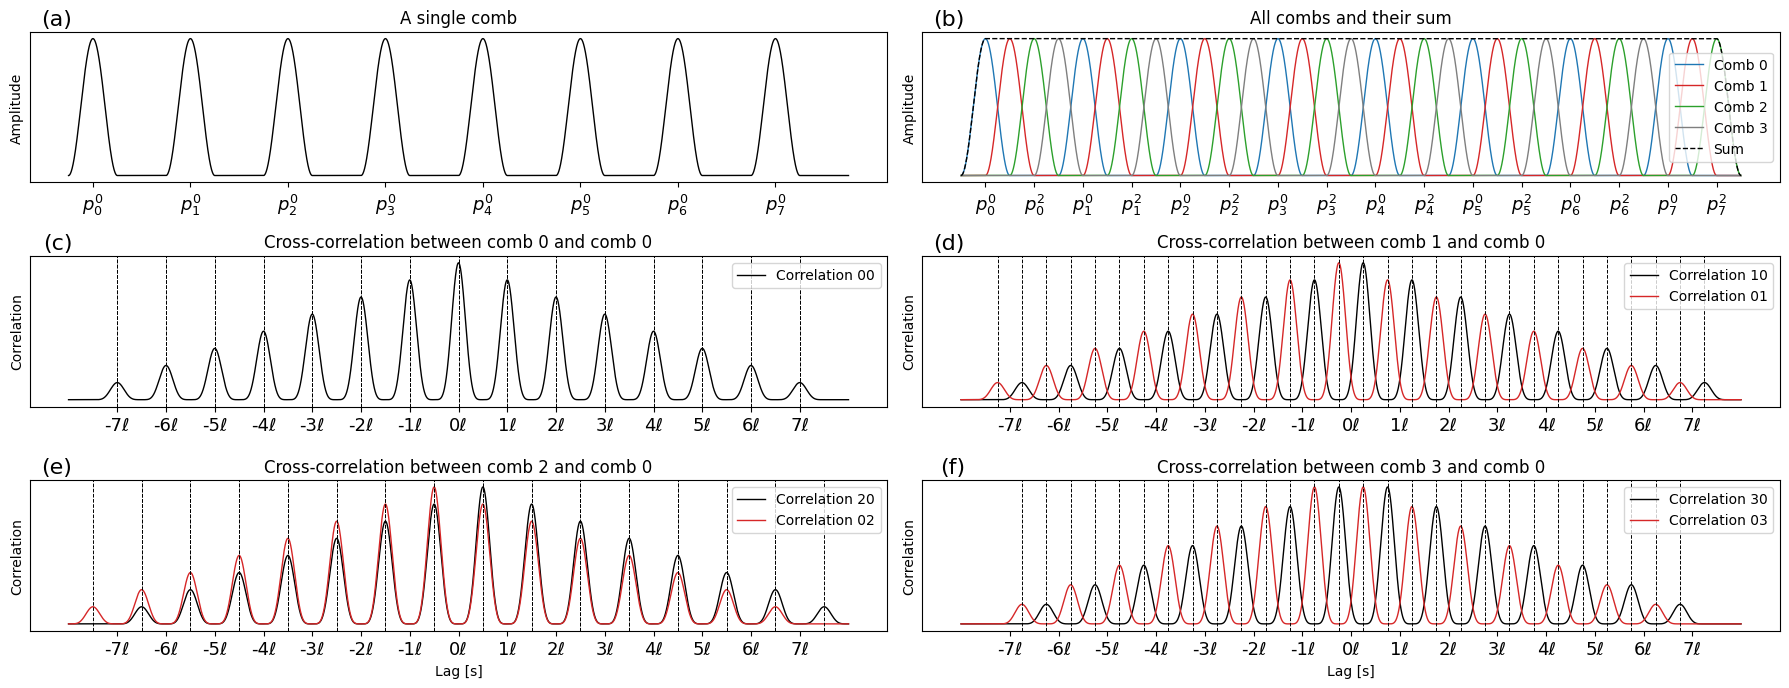

In [15]:
# You might change the lengths len1 and len2 to see how the combs look like. However make sure that len2//len1 >4 because we use 4 overlapping combs.
len1 = 2**10  # subsegment length $\ell$ used for the data selection
len2 = 2**14  # Length of the signal assuming a single segment (Q=1). Thus the segment L is the total length of the signal.
comb = getCombs(len1, len2)
central_lags_dict = {}

### Generate the central lags dictionary for the combs. Each combination i, j have specific central time lag, as can be seen on the figure.
for i in range(4):
    central_lags_dict[f'{i}{i}'] = CalculateLags(i, i, len1, len2)
    for j in range(i):
        central_lags_dict[f'{i}{j}'] = CalculateLags(i, j, len1, len2)

plotCombs(comb, len1,len2,central_lags_dict)

### First, we define a sinusoidal signal with noise which will be used to illustrate the steps

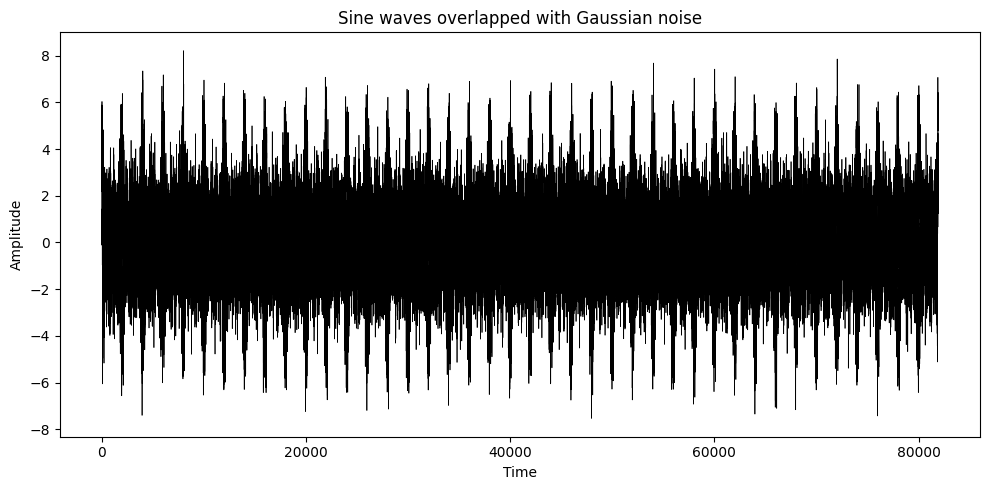

In [16]:
Q=20 # Total number of segments (which will be subdivided)

len2 = 2**12 # Length L of one segment 
len1 = 2**8 # Length of the subsegment $\ell$ used for the data selection

generator = np.random.default_rng() # Random number generator
data = 1*generator.normal(size=len2*Q) # Generate a random signal with a Gaussian distribution
freqs = [ 6*1e-3,7*1e-3, 8*1e-3,7.5*1e-3,8.5*1e-3] # Define some frequencies to add to the signal. Here we are in the mHz range because the scope of the study was in this range.
#freqs = np.arange(5*1e-3,6.1*1e-3,1e-4)
sine=np.zeros((len2*Q))
for freq in freqs:
    sine+=np.sin(np.arange(len2*Q) * 2 * np.pi *freq)
#sine =  + np.sin(np.arange(len2*Q) * 2 * np.pi / len2*Q) + np.sin(np.arange(len2*Q) * 4 * np.pi / len2*Q) +np.sin(np.arange(len2*Q) * 6 * np.pi / len2*Q) +np.sin(np.arange(len2*Q) * 10 * np.pi / len2*Q) + np.sin(np.arange(len2*Q) * 12 * np.pi / len2*Q) + np.sin(np.arange(len2*Q) * 14 * np.pi / len2*Q)
data += sine

fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(data, color='black', lw=0.5)
ax.set_title('Sine waves overlapped with Gaussian noise')
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')
plt.tight_layout()
plt.savefig('Figures/SyntheticSignal.png', dpi=300)

### Next, we define a resolution length $L$ and a selection length $\ell$ to segment the signal, and randomly discard sub-segments. We compute the bias ACF $\zeta$ (Eq. 12) based on the data including muted sub-segments.

In [17]:
def getPhi(Correction,central_lag_list, central_lag_ij_array,fft_segments, len1, len2):
    
    zeta_separate= np.zeros((len(central_lag_list), 2*len2-1))  # shape (nLagBins, 2*len2-1)
    lags_acf = np.arange(-len2 + 1, len2)  # lags for the ACF, from -L+1 to L-1
    lag_to_idx = {lag: k for k, lag in enumerate(central_lag_list)}
    
    for i in range(4):
        auto_spec = fft_segments[:,i,:] * np.conj(fft_segments[:,i,:])
        inverse_fft = np.fft.ifft(auto_spec, axis=-1).real
        inverse_fft = np.fft.fftshift(inverse_fft, axes=-1)  # center lags
        
        central_lags = central_lag_ij_array[i, i]
        for lag in central_lags:
            central_idx = lag_to_idx[lag]
            acf_index = np.where(lags_acf == lag)[0][0]


            extract = np.mean(inverse_fft[:, acf_index-len1 : acf_index+len1+1], axis=0)
            temp = np.zeros((2*len2-1))
            temp[acf_index-len1 : acf_index+len1+1] = extract
            zeta_separate[central_idx] += temp  # shape (nLagBins, 2*len2-1)
        

        for j in range(i):
            cross_spec = fft_segments[:,i,:] * np.conj(fft_segments[:,j,:])
            inverse_fft = np.fft.ifft(cross_spec, axis=-1).real
            inverse_fft = np.fft.fftshift(inverse_fft, axes=-1)  # center lags
        
            

            central_lags = central_lag_ij_array[i, j]
            for lag in central_lags:
                central_idx = lag_to_idx[lag]
                acf_index = np.where(lags_acf == lag)[0][0]

                #print(inverse_fft[:, central_idx-len1 : central_idx+len1+1].shape)
                extract = np.mean(inverse_fft[:, acf_index-len1 : acf_index+len1+1], axis=0)
                temp = np.zeros((2*len2-1))
                temp[acf_index-len1 : acf_index+len1+1] = extract
                zeta_separate[central_idx] += temp
                
                #if i != j:
                central_idx_flip = lag_to_idx[-lag]
                extracts_flipped = np.flip(temp)
                zeta_separate[central_idx_flip] += extracts_flipped
            

    ## SUM ACF IS NOW SHAPE (n_terms, 2*len2-1 ) --> Assemble the final ACF for each central lag
    zeta_k = np.zeros((2*len2-1))  # Initialize the biased ACF
    phi_k = np.zeros((2*len2-1))  # Initialize the unbiased ACF
    
    for lag in central_lag_list:
        index = lag_to_idx[lag]
        zeta_k += zeta_separate[index]
        phi_k += zeta_separate[index] / Correction[index]
    
    
    
    return phi_k, zeta_k

31
total number of teeth: 640
total number of discarded teeth : 0
Proportion:  0.0
Selection array shape: (20, 3, 8)


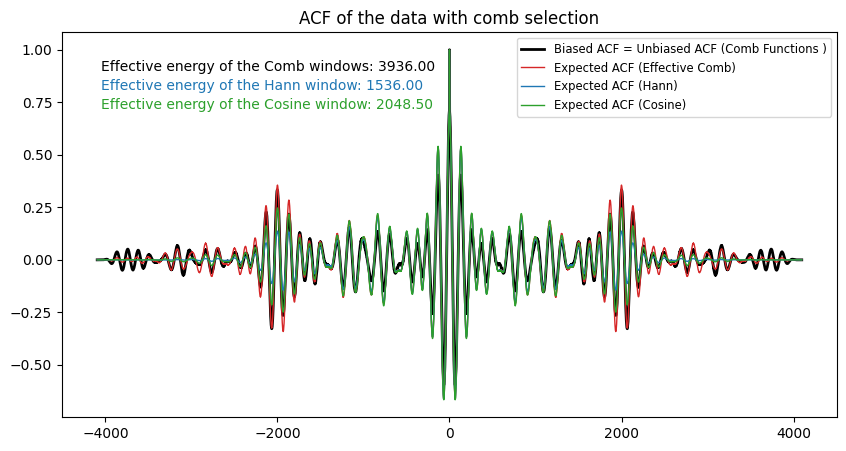

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [18]:
combs = getCombs(len1, len2)
big_window=np.sum(combs,axis=0) # This is the equialent window (it looks like a tukey window, mostly flat in the middle and tapering at the edges)
effective_sum= np.sum(big_window**2)  # Effective sum of the window, used for normalization

# Calculate the number of combs and segments in each comb
P  = (len2//len1)*2 -1
print(P)
#Initialise the selection list sigma (Eq 10 and text below)
selection_list_full = np.ones(((P+1)*Q))

#Randomly discard some teeth to simulate the selection process
random_discard = np.random.randint(0, high=Q*P, size=0)

# Parse the random discard list and set the corresponding teeth in the selection list to 0
for i in range(len(selection_list_full)):
    if i in random_discard:
        selection_list_full[i] = 0

#Print some statistics about the selection
print('total number of teeth:', len(selection_list_full))
print('total number of discarded teeth :', len(set(random_discard)))
prop=len(set(random_discard))/len(selection_list_full)
print('Proportion: ', prop)

# Initialise the lag lists
central_lag_list=sorted(InitialiseLagList(len1,len2))
central_lag_ij_array = getCentralLagArray(len1, len2)

### Initalise the count and correction dictionary
Correction=getCorrection(Q,P,selection_list_full,selection_list_full,central_lag_ij_array,central_lag_list)

selection_array, selection_array_i3 = getSelectionArrays(Q,P, selection_list_full)
print('Selection array shape:', selection_array.shape)
########### PREPARE THE DATA : Mute the p selected sub-segments ###########

mute_mask = np.ones((Q, 4, len2))

for i in range(4):
    if i<3:
        selection_list = selection_array[:, i]
        len_ = selection_list.shape[1]  # Length of the selection list for the current comb
    else:
        selection_list = selection_array_i3[:,0]
        len_ = selection_list.shape[1]
    for j in range(len_):
        mute_mask[:, i, i*len1//2 + 2*j*len1:i*len1//2 + 2*(j+1)*len1] *= selection_list[:,j][:, np.newaxis]
    

#### VECTORIZED OPERATION FOR THE SEGMENT MUTING ####
comb_array = np.tile(combs, (Q, 1, 1))  # (Q, 4, len2)
comb_array *= mute_mask  # now all Q combs are pre-masked

# Roll the data segments according to the shifts
roll_shifts = -np.arange(Q)*(len2 - len1//2) # Take the overlap into account (half sub-segment length to ensure a flat equivalent windowing taper)
data_rolled = np.zeros((Q, 4, len2))
for q in range(Q):
    data_rolled[q] = np.tile(np.roll(data, roll_shifts[q], axis=-1)[:len2], (4, 1))  # shape (Q, 4, len2)
        
### Vectorized calculation of the fourrier transforms
segments = comb_array * data_rolled  # shape (Q, 4, len2)
nfft = 2*len2-1
fft_segments = np.fft.fft(np.pad(segments, ((0,0),(0,0),(0,len2-1))), axis=-1)


phi,zeta = getPhi(Correction,central_lag_list, central_lag_ij_array,fft_segments, len1, len2)
zeta/= effective_sum  # Normalize by the effective taper
zeta_ideal = zeta.copy()  # Keep a copy of the ideal zeta for comparison
welch_acf = getWelchACF(data, len2, big_window)
hann = get_window('hann', len2)  # Create a Hann window
cosine = get_window('cosine', len2)  # Create a Cosine window
welch_acf_hann = getWelchACF(data, len2, hann)
welch_acf_cosine = getWelchACF(data, len2, cosine)


effective_energies = [effective_sum, np.sum(hann**2), np.sum(cosine**2)]

#### PLOT THE RESULTS ####

lags_acf = np.arange(-len2+1, len2)    
fig,ax= plt.subplots(1,1,figsize=(10,5))

ax.plot(lags_acf, zeta_ideal/np.max(zeta_ideal), color='black', lw=2, label='Biased ACF = Unbiased ACF (Comb Functions )')
ax.set_title('ACF of the data with comb selection')
ax.plot(lags_acf, welch_acf/np.max(welch_acf), color='tab:red', lw=1, label='Expected ACF (Effective Comb)')
ax.plot(lags_acf, welch_acf_hann/np.max(welch_acf_hann), color='tab:blue', lw=1, label='Expected ACF (Hann)')
ax.plot(lags_acf, welch_acf_cosine/np.max(welch_acf_cosine), color='tab:green', lw=1, label='Expected ACF (Cosine)')

for i in range(3):
    ax.text(0.05, 0.9 - i*0.05, f'Effective energy of the {["Comb windows", "Hann window", "Cosine window"][i]}: {effective_energies[i]:.2f}', transform=ax.transAxes, color=['black', 'tab:blue', 'tab:green'][i])
#ax.plot(lags_acf,zeta/np.max(welch_acf) - welch_acf/np.max(welch_acf), color='k', linestyle='--', label='DIFF')
ax.legend(fontsize='small')
plt.savefig('Figures/ACF_Comparison.png', dpi=300)
plt.show()

from IPython.display import display, Math

display(Math(r'\large{\text{We compare with different windows to outline the intrinsic difference in amplitude between different windows.}}'))
display(Math(r'\large{\text{The main point here is that the Welch ACF retrieved using the effective window gives a closer result to the one obtained with the overlapping comb functions.}}'))
display(Math(r'\large{\text{Using other windows such as the Hann or Cosine windows gives a different result, which is expected because the effective window is not the same as these windows.}}'))


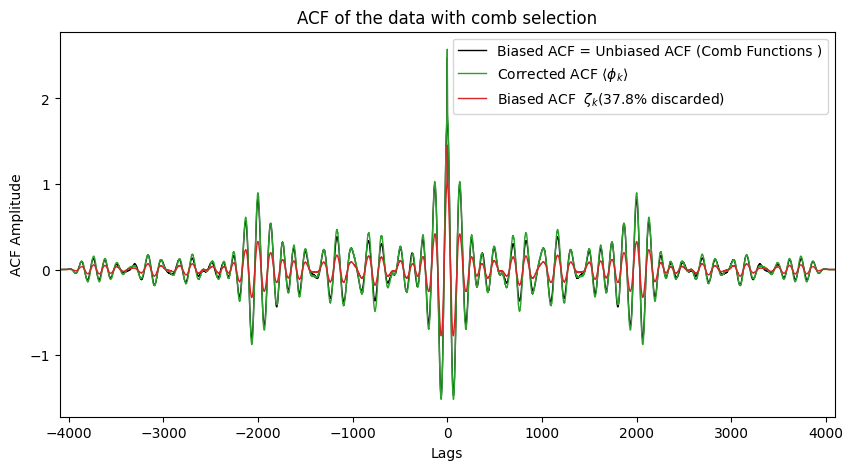

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [19]:
#Initialise the selection list sigma (Eq 10 and text below)
selection_list_full = np.ones(((P+1)*Q))

###### HERE WE CONTROL HOW MAY TEETH ARE DISCARDED ######
random_discard = np.random.randint(0, high=Q*P, size=Q*P//2)
#random_discard = np.random.randint(0, high=Q*P, size=0)

# Parse the random discard list and set the corresponding teeth in the selection list to 0
for i in range(len(selection_list_full)):
    if i in random_discard:
        selection_list_full[i] = 0

prop=len(set(random_discard))/len(selection_list_full)

combs = getCombs(len1, len2)
big_window=np.sum(combs,axis=0) # This is the equialent window (it looks like a tukey window, mostly flat in the middle and tapering at the edges)
effective_sum= np.sum(big_window**2)  # Effective sum of the window, used for normalization

lags_acf= np.arange(-len2 + 1, len2, 1)
sum_ccf_separate={f'{comb}_{lag}': [] for comb in range(Q) for lag in central_lag_list}

central_lag_list=InitialiseLagList(len1,len2)

# Get the amplitude bias correction (Eq. 15)
Correction=getCorrection(Q,P,selection_list_full,selection_list_full,central_lag_ij_array,central_lag_list)
selection_array, selection_array_i3 = getSelectionArrays(Q,P, selection_list_full)
################################# PREPARE THE DATA : Mute the p selected sub-segments #################################
mute_mask = np.ones((Q, 4, len2))


for i in range(4):
    if i<3:
        selection_list = selection_array[:, i]
        len_ = selection_list.shape[1]  # Length of the selection list for the current comb
    else:
        selection_list = selection_array_i3[:,0]
        len_ = selection_list.shape[1]
    for j in range(len_):
        mute_mask[:, i, i*len1//2 + 2*j*len1:i*len1//2 + 2*(j+1)*len1] *= selection_list[:,j][:, np.newaxis]
        

comb_array = np.tile(combs, (Q, 1, 1))  # (Q, 4, len2)
comb_array *= mute_mask  # now all Q combs are pre-masked

# Roll the data segments according to the shifts
roll_shifts = -np.arange(Q)*(len2 - len1//2) # Take the overlap into account (half sub-segment length to ensure a flat equivalent windowing taper)
data_rolled = np.zeros((Q, 4, len2))
for q in range(Q):
    data_rolled[q] = np.tile(np.roll(data, roll_shifts[q], axis=-1)[:len2], (4, 1))  # shape (Q, 4, len2)
        
### Vectorized calculation of the fourrier transforms
segments = comb_array * data_rolled  # shape (Q, 4, len2)
nfft = 2*len2-1
fft_segments = np.fft.fft(np.pad(segments, ((0,0),(0,0),(0,len2-1))), axis=-1)

phi,zeta_k = getPhi(Correction,central_lag_list, central_lag_ij_array,fft_segments, len1, len2)
zeta_k/= effective_sum  # Normalize by the effective taper
phi/= effective_sum
welch_acf = getWelchACF(data, len2, big_window)



################################# PLOT THE RESULTS #################################
lags_acf = np.arange(-len2+1, len2)    
fig,ax= plt.subplots(1,1,figsize=(10,5))

#ax.plot(lags_acf, zeta_ideal/np.max(zeta_ideal), color='tab:red', lw=1, label='Biased ACF = Unbiased ACF (No selection )')
ax.plot(lags_acf, zeta_ideal, color='black', lw=1, label='Biased ACF = Unbiased ACF (Comb Functions )')
ax.plot(lags_acf, phi, color='tab:green', lw=1, label=f'Corrected ACF 'r'$\langle\phi_k\rangle$')
ax.plot(lags_acf, zeta_k, color='tab:red', lw=1, label=f'Biased ACF  'r'$\zeta_k$' f'({prop*100:.1f}% discarded)')

ax.set_title('ACF of the data with comb selection')
ax.set_xlabel('Lags')
ax.set_ylabel('ACF Amplitude')
ax.set_xlim(-len2+1, len2-1)
#ax.plot(lags_acf,zeta/np.max(welch_acf) - welch_acf/np.max(welch_acf), color='k', linestyle='--', label='DIFF')
ax.legend()
plt.savefig('Figures/ACF_Recovery.png', dpi=300)
plt.show()

from IPython.display import display, Math
display(Math(r'\large{\text{The corrected ACF }\langle\phi_k\rangle\ \text{matches the unbiased ACF obtained in the previous cell, that is when no teeth are discarded.}}'))
display(Math(r'\large{\text{The biased ACF }\zeta_k\ \text{is the one that is actually computed from the data, and it is biased by the selection of teeth.}}'))